In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class_names = ['ant', 'axe', 'bear', 'bee', 'nose']
num_classes = 5
img_size = 28
batch_size = 32
samples_per_class = 5000

In [3]:
def load_data(class_names, samples_per_class):
    images = []
    labels = []
    
    for idx, class_name in enumerate(class_names):
        data = np.load(f'dataset/full_numpy_bitmap_{class_name}.npy')
        data = data[:samples_per_class] 
        images.append(data)
        labels.extend([idx] * len(data))
    
    images = np.concatenate(images, axis=0)
    images = images.reshape(-1, 28, 28, 1)
    labels = np.array(labels)
    
    return images, labels

In [4]:
images, labels = load_data(class_names, samples_per_class)

In [5]:
images.shape

(25000, 28, 28, 1)

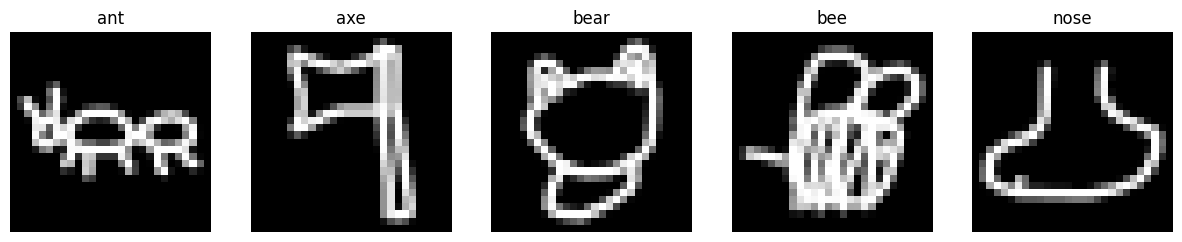

In [6]:
# lets look at the first image of each class
plt.figure(figsize=(15, 3))
for i in range(5):
    idx = np.where(labels == i)[0][0]     
    plt.subplot(1, 5, i+1)
    plt.imshow(images[idx].squeeze(), cmap='gray')  
    plt.title(class_names[i])
    plt.axis('off')
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

In [8]:
from tensorflow import keras

In [9]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 127.5 - 1.0, label


In [10]:
data_augmentation = keras.Sequential([
    layers.RandomRotation(
        factor=0.15,  
        fill_mode='constant',
        fill_value=0.0  
    ),
    layers.RandomZoom(
        height_factor=(-0.1, 0.2),  
        width_factor=(-0.1, 0.2),
        fill_mode='constant',
        fill_value=0.0  
    ), 
    layers.RandomTranslation(
        height_factor=0.1,
        width_factor=0.1,
        fill_mode='constant',
        fill_value=0.0  
    )
])

In [11]:
def create_dataset(images, labels, batch_size=32, augment=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
  
    if augment:
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x, training=True), y),  
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset = dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [12]:
batch_size = 64
train_dataset = create_dataset(X_train, y_train, batch_size=batch_size, augment=True)
val_dataset = create_dataset(X_val, y_val, batch_size=batch_size, augment=False)

In [13]:
def plot_augmented_images(dataset, class_names, n_images=5):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(15, 3))
        for i in range(n_images):
            plt.subplot(1, n_images, i+1)
            img = (images[i].numpy() + 1.0) * 127.5 # denormalize
            plt.imshow(img, cmap='gray')
            plt.title(class_names[labels[i].numpy()])
            plt.axis('off')
        plt.show()

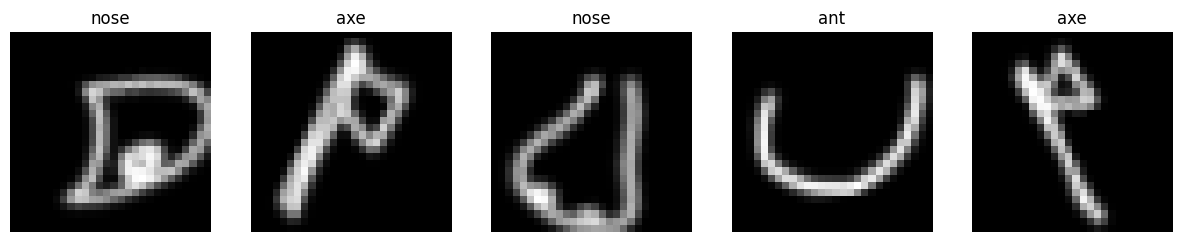

In [14]:
plot_augmented_images(train_dataset, class_names)

# Task 2

In [15]:
latent_dim = 100

In [16]:
# resnet
def make_generator_model_1():
    noise_input = layers.Input(shape=(latent_dim,))
    label_input = layers.Input(shape=(1,))
      
    label_embedding = layers.Embedding(5, 50)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    
    combined = layers.Concatenate()([noise_input, label_embedding])
    
    x = layers.Dense(7*7*256)(combined)
    x = layers.Reshape((7, 7, 256))(x)
    
    # residual block 1
    def residual_block(x, filters):
        shortcut = x
        x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        return layers.Add()([x, shortcut])
    
    x = residual_block(x, 256)
    
    # upsample
    x = layers.Conv2DTranspose(128, 5, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # residual block 2
    x = residual_block(x, 128)
    
    x = layers.Conv2DTranspose(64, 5, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    output = layers.Conv2DTranspose(1, 5, padding='same', activation='tanh')(x)
    
    return keras.Model([noise_input, label_input], output)

def make_discriminator_model_1():
    img_input = layers.Input(shape=(28,28,1))
    label_input = layers.Input(shape=(1,))
    
    label_embedding = layers.Embedding(5, 50)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    label_embedding = layers.Dense(28*28)(label_embedding)
    label_embedding = layers.Reshape((28,28,1))(label_embedding)
    
    combined = layers.Concatenate(axis=-1)([img_input, label_embedding])  
    
    x = layers.Conv2D(64, 5, strides=2, padding='same')(combined)
    x = layers.LeakyReLU(0.2)(x)  # (14,14,64)
    
    def residual_block(x, filters):
        shortcut = x

        if shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, 1)(shortcut)  # 1x1 conv 
    
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.Conv2D(filters, 3, padding='same')(x)
        return layers.Add()([x, shortcut])
    
    x = residual_block(x, 128)  # (14,14,128)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    
    return keras.Model([img_input, label_input], x)

In [17]:
# Тест генерации
generator = make_generator_model_1()
noise = tf.random.normal([1, latent_dim])
label = tf.constant([[3]])
generated_img = generator([noise, label])
print("Генератор:", generated_img.shape)  # Должно быть (1, 28, 28, 1)

# Тест дискриминации
discriminator = make_discriminator_model_1()
decision = discriminator([generated_img, label])  
print("Дискриминатор:", decision.shape)  # Должно быть (1, 1)

# Тест совместимости
try:
    assert generated_img.shape[1:] == discriminator.input_shape[0][1:]
    print("Совместимость подтверждена")
except AssertionError as e:
    print(f"Ошибка совместимости: {str(e)}")


Генератор: (1, 28, 28, 1)
Дискриминатор: (1, 1)
Совместимость подтверждена


In [21]:
# sagan 
def self_attention_block(x):
    batch, H, W, C = tf.unstack(tf.shape(x))
    f = layers.Conv2D(C//8, 1)(x)
    g = layers.Conv2D(C//8, 1)(x)
    h = layers.Conv2D(C, 1)(x)
    
    s = tf.matmul(
        tf.reshape(g, [batch, H*W, C//8]), 
        tf.reshape(f, [batch, H*W, C//8]), transpose_b=True
    )
    beta = tf.nn.softmax(s)
    o = tf.matmul(beta, tf.reshape(h, [batch, H*W, C]))
    o = tf.reshape(o, [batch, H, W, C])
    return layers.LayerNormalization()(o + x)

def make_generator_model_2(latent_dim=100):
    noise = layers.Input(shape=(latent_dim,))
    label = layers.Input(shape=(1,))
    
    label_embed = layers.Embedding(5, 50)(label)
    label_embed = layers.Dense(latent_dim)(label_embed)
    label_embed = layers.Reshape((latent_dim,))(label_embed)
    

    combined = layers.Multiply()([noise, label_embed])
    

    x = layers.Dense(7*7*256)(combined)
    x = layers.Reshape((7,7,256))(x)
    

    x = layers.Conv2DTranspose(128, 5, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    

    x = self_attention_block(x)
    

    x = layers.Conv2DTranspose(64, 5, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    

    out = layers.Conv2D(1, 7, padding='same', activation='tanh')(x)
    
    return keras.Model([noise, label], out)

def make_discriminator_model_2():
    img = layers.Input(shape=(28,28,1))
    label = layers.Input(shape=(1,))
    
    label_embed = layers.Embedding(5, 50)(label)
    label_embed = layers.Dense(28*28)(label_embed)
    label_embed = layers.Reshape((28,28,1))(label_embed)
    
    combined = layers.Concatenate(axis=-1)([img, label_embed])
    
    x = layers.Conv2D(64, 5, strides=2, padding='same')(combined)
    x = layers.LeakyReLU(0.2)(x)
    
    x = self_attention_block(x)
    
    x = layers.Conv2D(128, 5, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    
    return keras.Model([img, label], out)

In [24]:
# Тест генерации
generator = make_generator_model_2()
noise = tf.random.normal([1, 100])
label = tf.constant([[3]])  # Класс 3
generated_img = generator([noise, label])
print("Генератор:", generated_img.shape)  # (1, 28, 28, 1)

# Тест дискриминации
discriminator = make_generator_model_2()
decision = discriminator([generated_img, label])
print("Дискриминатор:", decision.shape)  # (1, 1)

# Проверка совместимости
assert generated_img.shape[1:] == discriminator.input_shape[0][1:]
print("✅ Совместимость подтверждена")

TypeError: Keras symbolic inputs/outputs do not implement `__len__`. You may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model. This error will also get raised if you try asserting a symbolic input/output directly.

In [24]:
# dense U-net
def make_dense_generator_model_3():
    def dense_block(x, filters, num_layers=3):
        for _ in range(num_layers):
            y = layers.Conv2DTranspose(filters, 3, padding='same')(x)
            y = layers.InstanceNormalization()(y)
            y = layers.LeakyReLU(0.2)(y)
            x = layers.Concatenate()([x, y])
        return x

    latent = keras.Input(shape=(latent_dim,))

    x = layers.Dense(7*7*256)(latent)
    x = layers.Reshape((7, 7, 256))(x)
    

    x = dense_block(x, 128)
    x = layers.UpSampling2D(2)(x)  # 14x14
    
    x = dense_block(x, 64)
    x = layers.UpSampling2D(2)(x)  # 28x28
    
    x = self_attention_block(x)
    
    outputs = layers.Conv2D(1, 7, padding='same', activation='tanh')(x)
    
    return keras.Model(latent, outputs)

def make_discriminator_model_3():
    def spectral_conv(filters, kernel, strides):
        conv = layers.Conv2D(filters, kernel, strides=strides, padding='same')
        return layers.SpectralNormalization(conv)

    inp = keras.Input(shape=(28,28,1))
    
    x = spectral_conv(64, 5, 2)(inp)  # 14x14
    x = layers.LeakyReLU(0.2)(x)
    
    x = spectral_conv(128, 5, 2)(x)  # 7x7
    x = layers.LeakyReLU(0.2)(x)
    
    x = self_attention_block(x)
    
    # multiscale features
    x1 = layers.GlobalMaxPooling2D()(x)
    x2 = layers.GlobalAvgPool2D()(x)
    x = layers.Concatenate()([x1, x2])
    
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    return keras.Model(inp, outputs)